In [41]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [42]:
#  Load Dataset
df = pd.read_csv("/content/Sleep_health_and_lifestyle_dataset.csv")
print(df)

     Person ID  Gender  Age            Occupation  Sleep Duration  \
0            1    Male   27     Software Engineer             6.1   
1            2    Male   28                Doctor             6.2   
2            3    Male   28                Doctor             6.2   
3            4    Male   28  Sales Representative             5.9   
4            5    Male   28  Sales Representative             5.9   
..         ...     ...  ...                   ...             ...   
369        370  Female   59                 Nurse             8.1   
370        371  Female   59                 Nurse             8.0   
371        372  Female   59                 Nurse             8.1   
372        373  Female   59                 Nurse             8.1   
373        374  Female   59                 Nurse             8.1   

     Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                   6                       42             6   Overweight   
1                

In [43]:

# Preprocessing steps:

# Find missing values
print("Dataset Info:")
print(df.info())
print("\nMissing values in each column:")
df['Sleep Disorder'].fillna('No Sleeping Disorders', inplace=True)
print(df.isnull().sum())

# Remove duplicates and prepare for analysis
df.drop_duplicates(inplace=True)

# Split 'Blood Pressure' into 'Systolic' and 'Diastolic'
bp_split = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic'] = pd.to_numeric(bp_split[0], errors='coerce')
df['Diastolic'] = pd.to_numeric(bp_split[1], errors='coerce')
df.drop(columns=['Blood Pressure'], inplace=True)

# Encoding categorical columns
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

#  Features and target
target = 'Stress Level'
X = df.drop(columns=[target])
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB
None

Mi

EXPLORATORY DATA ANALYSIS

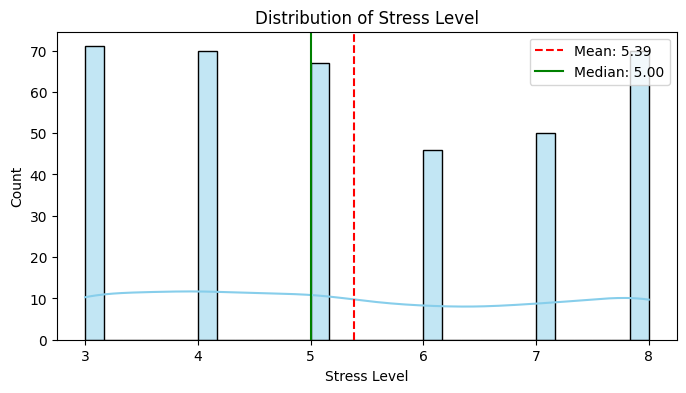

Stress Level Mean: 5.39
Stress Level Median: 5.00
Stress Level Standard Deviation: 1.77


In [44]:

# 1. Distribution of Stress Level
# Histogram of Target Variable with Mean and Median Lines
plt.figure(figsize=(8, 4))
sns.histplot(df[target], kde=True, bins=30, color='skyblue')
plt.title(f"Distribution of {target}")

mean_val = df[target].mean()
median_val = df[target].median()

plt.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='g', linestyle='-', label=f'Median: {median_val:.2f}')
plt.legend()
plt.show()

print(f"{target} Mean: {mean_val:.2f}")
print(f"{target} Median: {median_val:.2f}")
print(f"{target} Standard Deviation: {df[target].std():.2f}")


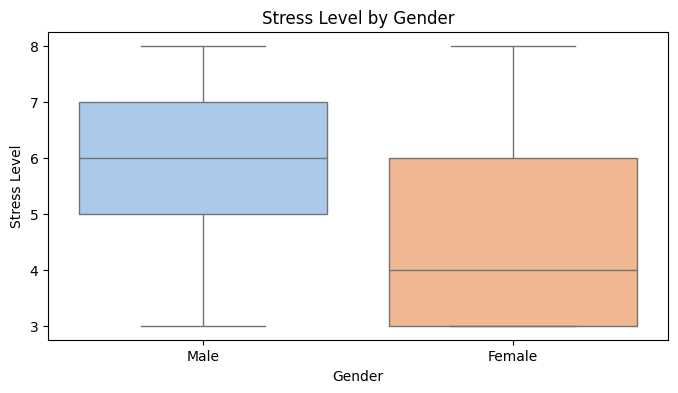

In [45]:
# 2. Gender vs Stress Level
# Decode back to original gender names for plotting
df['Gender Label'] = label_encoders['Gender'].inverse_transform(df['Gender'])

plt.figure(figsize=(8, 4))
sns.boxplot(x='Gender Label', y='Stress Level', data=df, palette='pastel')
plt.title('Stress Level by Gender')
plt.xlabel('Gender') # Add x-axis label
plt.show()

# Drop the temporary 'Gender Label' column
df.drop(columns=['Gender Label'], inplace=True)

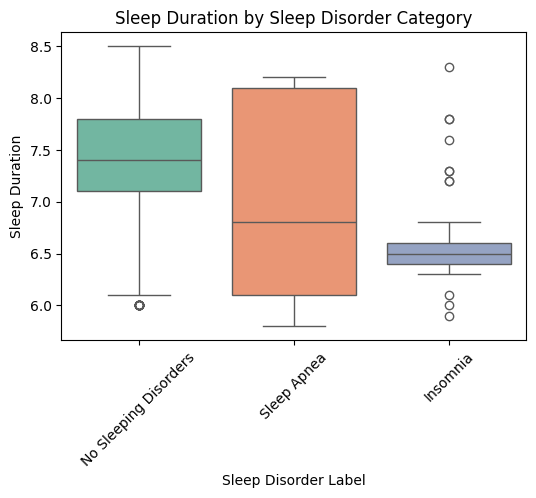

                       count      mean       std  min  25%  50%  75%  max
Sleep Disorder Label                                                     
Insomnia                77.0  6.589610  0.387157  5.9  6.4  6.5  6.6  8.3
No Sleeping Disorders  219.0  7.358447  0.732320  6.0  7.1  7.4  7.8  8.5
Sleep Apnea             78.0  7.032051  0.974812  5.8  6.1  6.8  8.1  8.2 



In [46]:
# 3. Sleep Duration across Sleep Disorder categories
# Decode back to original category names for plotting
df['Sleep Disorder Label'] = label_encoders['Sleep Disorder'].inverse_transform(df['Sleep Disorder'])

# Plot using the decoded labels
plt.figure(figsize=(6, 4))
sns.boxplot(x='Sleep Disorder Label', y='Sleep Duration', data=df, palette='Set2')
plt.title('Sleep Duration by Sleep Disorder Category')
plt.xticks(rotation=45)
plt.show()

# Grouped statistics by decoded labels
print(df.groupby('Sleep Disorder Label')['Sleep Duration'].describe(), "\n")


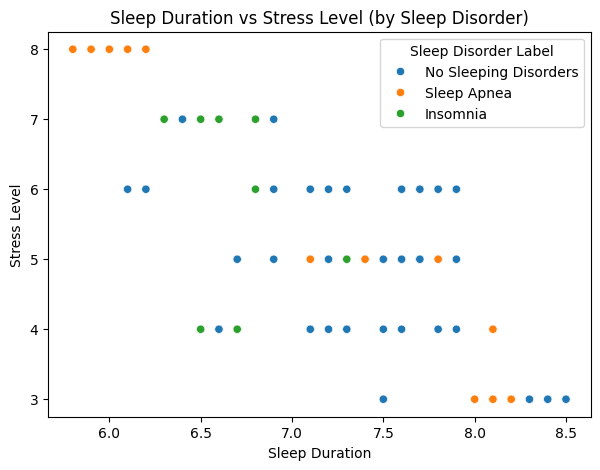

In [47]:
# 4. Scatter plot: Sleep Duration vs Stress Level
# Decode encoded labels back to original
df['Sleep Disorder Label'] = label_encoders['Sleep Disorder'].inverse_transform(df['Sleep Disorder'])

# Now plot using the decoded labels
plt.figure(figsize=(7, 5))
sns.scatterplot(x='Sleep Duration', y='Stress Level', hue='Sleep Disorder Label', data=df)
plt.title('Sleep Duration vs Stress Level (by Sleep Disorder)')
plt.show()


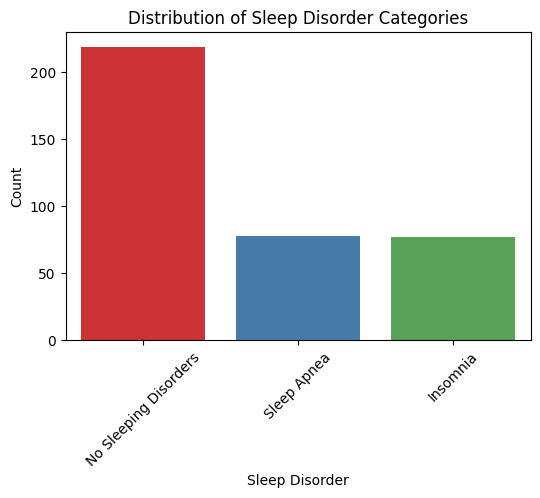

Sleep Disorder Label
No Sleeping Disorders    219
Sleep Apnea               78
Insomnia                  77
Name: count, dtype: int64


In [48]:
# 5. Count Plot: Sleep Disorder Distribution
# Decode back to original sleep disorder names
df['Sleep Disorder Label'] = label_encoders['Sleep Disorder'].inverse_transform(df['Sleep Disorder'])

# Plot using the decoded labels
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sleep Disorder Label', palette='Set1')
plt.title('Distribution of Sleep Disorder Categories')
plt.xlabel('Sleep Disorder')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Show counts of each sleep disorder category
counts = df['Sleep Disorder Label'].value_counts()
print(counts)


FEATURE SELECTION METHODS

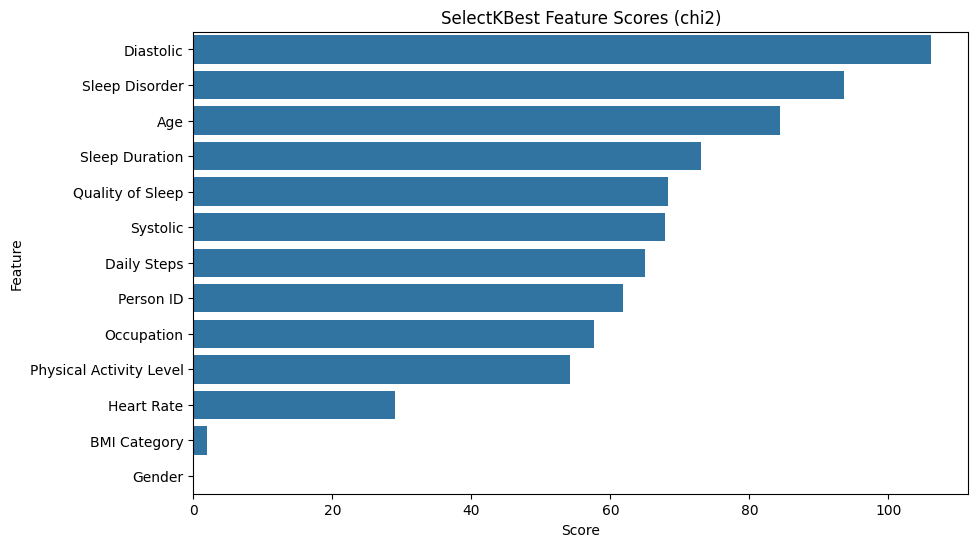


SelectKBest Feature Scores:
                    Feature       Score
12                Diastolic  106.186589
10           Sleep Disorder   93.616783
2                       Age   84.401550
4            Sleep Duration   72.973141
5          Quality of Sleep   68.283872
11                 Systolic   67.837643
9               Daily Steps   64.949159
0                 Person ID   61.891454
3                Occupation   57.700970
6   Physical Activity Level   54.265375
8                Heart Rate   28.985051
7              BMI Category    2.022354
1                    Gender    0.021090


In [49]:

# Feature 1. SelectKBest with chi2
kbest = SelectKBest(score_func=chi2, k='all')
kbest.fit(X_scaled.abs(), y)

feature_scores = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Score': kbest.scores_
}).sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=feature_scores)
plt.title("SelectKBest Feature Scores (chi2)")
plt.show()

print("\nSelectKBest Feature Scores:")
print(feature_scores)



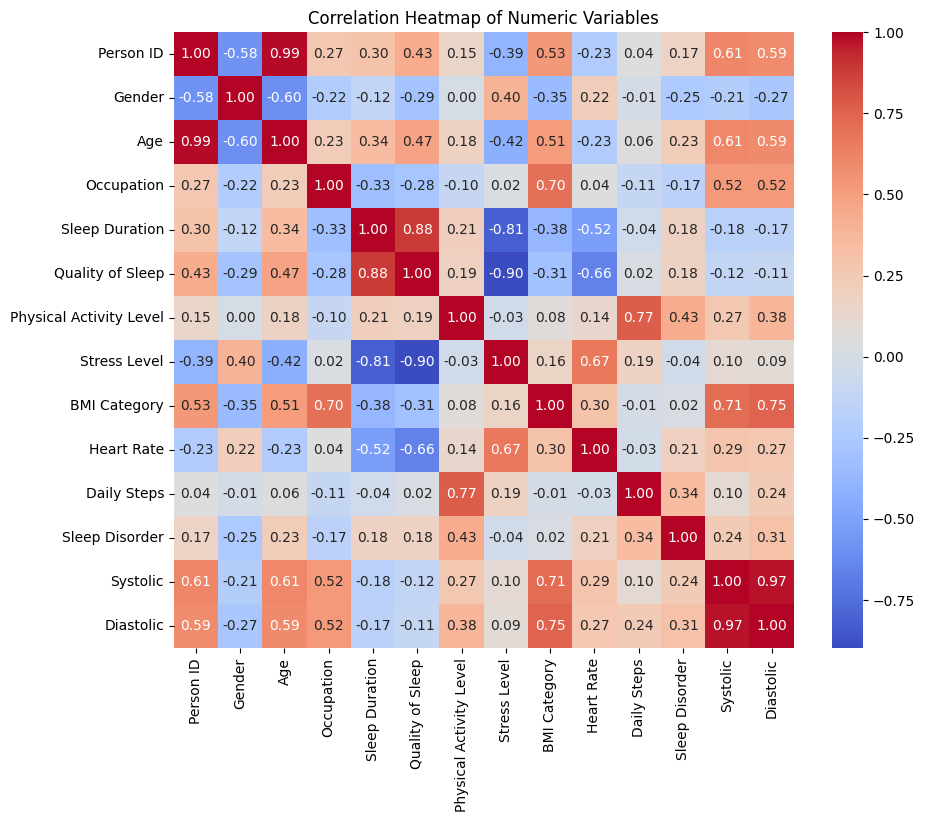

In [50]:
# Feature 2:Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()



MODEL 1: LOGISTIC REGRESSION

In [82]:
# Importing necessary libraries
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [83]:
# Define Features and Split Data
features = ['Diastolic', 'Sleep Duration', 'Quality of Sleep', 'Heart Rate','Sleep Disorder', 'Age', 'Systolic']
target = 'Stress Level'

X = df[features]
y = df[target]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

HYPERTUNING METHOD:GRIDSEARCH

In [84]:
# Grid Search for eta0
eta_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

best_eta = None
best_val_loss_eta = float("inf")
print("\nGrid Search for eta0")

for eta in eta_values:
    val_losses = []
    for train_idx, val_idx in skf.split(X_trainval_scaled, y_trainval):
        X_train_fold, X_val_fold = X_trainval_scaled[train_idx], X_trainval_scaled[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

        clf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=eta,
                            max_iter=100, warm_start=True, random_state=40)

        clf.partial_fit(X_train_fold, y_train_fold, classes=np.unique(y))

        for epoch in range(100):
            clf.partial_fit(X_train_fold, y_train_fold)

        y_val_prob = clf.predict_proba(X_val_fold)
        val_loss = log_loss(y_val_fold, y_val_prob)
        val_losses.append(val_loss)

    avg_val_loss = np.mean(val_losses)
    print(f"eta0={eta} | Avg Val Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss_eta:
        best_val_loss_eta = avg_val_loss
        best_eta = eta

print(f"\nBest eta0: {best_eta} with Avg Val Loss: {best_val_loss_eta:.4f}")



Grid Search for eta0
eta0=0.0001 | Avg Val Loss: 1.4064
eta0=0.0005 | Avg Val Loss: 0.9863
eta0=0.001 | Avg Val Loss: 0.8084
eta0=0.005 | Avg Val Loss: 0.5766
eta0=0.01 | Avg Val Loss: 0.5383
eta0=0.05 | Avg Val Loss: 0.5068
eta0=0.1 | Avg Val Loss: 0.5107

Best eta0: 0.05 with Avg Val Loss: 0.5068


In [85]:
# Grid Search for alpha
alpha_values = [0.0001, 0.001, 0.01, 0.1]
best_alpha = None
best_val_loss_alpha = float("inf")
print("\nGrid Search for alpha")

for alpha in alpha_values:
    val_losses = []
    for train_idx, val_idx in skf.split(X_trainval_scaled, y_trainval):
        X_train_fold, X_val_fold = X_trainval_scaled[train_idx], X_trainval_scaled[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

        clf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=best_eta, alpha=alpha,
                            max_iter=100, warm_start=True, random_state=40)

        clf.partial_fit(X_train_fold, y_train_fold, classes=np.unique(y))
        for epoch in range(100):
            clf.partial_fit(X_train_fold, y_train_fold)

        y_val_prob = clf.predict_proba(X_val_fold)
        val_loss = log_loss(y_val_fold, y_val_prob)
        val_losses.append(val_loss)

    avg_val_loss = np.mean(val_losses)
    print(f"alpha={alpha} | Avg Val Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss_alpha:
        best_val_loss_alpha = avg_val_loss
        best_alpha = alpha

print(f"\nBest alpha: {best_alpha} with Avg Val Loss: {best_val_loss_alpha:.4f}")



Grid Search for alpha
alpha=0.0001 | Avg Val Loss: 0.5068
alpha=0.001 | Avg Val Loss: 0.5083
alpha=0.01 | Avg Val Loss: 0.6089
alpha=0.1 | Avg Val Loss: 0.9567

Best alpha: 0.0001 with Avg Val Loss: 0.5068


In [86]:
# Grid Search for penalty
penalty_values = ['l1', 'l2', 'elasticnet']
best_penalty = None
best_val_loss_penalty = float("inf")
print("\nGrid Search for penalty")

for penalty in penalty_values:
    val_losses = []
    for train_idx, val_idx in skf.split(X_trainval_scaled, y_trainval):
        X_train_fold, X_val_fold = X_trainval_scaled[train_idx], X_trainval_scaled[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

        clf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=best_eta,
                            alpha=best_alpha, penalty=penalty, max_iter=100,
                            random_state=40)

        clf.fit(X_train_fold, y_train_fold)
        y_val_prob = clf.predict_proba(X_val_fold)
        val_loss = log_loss(y_val_fold, y_val_prob)
        val_losses.append(val_loss)

    avg_val_loss = np.mean(val_losses)
    print(f"penalty={penalty} | Avg Val Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss_penalty:
        best_val_loss_penalty = avg_val_loss
        best_penalty = penalty

print(f"\nBest penalty: {best_penalty} with Avg Val Loss: {best_val_loss_penalty:.4f}")



Grid Search for penalty
penalty=l1 | Avg Val Loss: 0.5095
penalty=l2 | Avg Val Loss: 0.5105
penalty=elasticnet | Avg Val Loss: 0.5097

Best penalty: l1 with Avg Val Loss: 0.5095


In [87]:
# Final Training with Early Stopping
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_trainval)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_trainval)
class_weights = dict(zip(classes, weights))

# Using hyperparameter values
clf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0= 0.001,
                    alpha=best_alpha, penalty=best_penalty,
                    max_iter=100, class_weight=class_weights,  warm_start=True, random_state=40)

clf.partial_fit(X_trainval_scaled, y_trainval, classes=classes)

train_loss, test_loss = [], []
train_acc, test_acc = [], []
no_improve = 0
best_loss = float("inf")
patience = 7
epochs = 100

for epoch in range(epochs):
    clf.partial_fit(X_trainval_scaled, y_trainval)

    y_train_pred = clf.predict(X_trainval_scaled)
    y_test_pred = clf.predict(X_test_scaled)
    y_train_prob = clf.predict_proba(X_trainval_scaled)
    y_test_prob = clf.predict_proba(X_test_scaled)

    loss_train = log_loss(y_trainval, y_train_prob)
    loss_test = log_loss(y_test, y_test_prob)
    acc_train = accuracy_score(y_trainval, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)

    train_loss.append(loss_train)
    test_loss.append(loss_test)
    train_acc.append(acc_train)
    test_acc.append(acc_test)

    print(f"Epoch {epoch+1:03d} | Train Acc: {acc_train:.4f} | Test Acc: {acc_test:.4f} | Train Loss: {loss_train:.4f} | Test Loss: {loss_test:.4f}")

    if loss_test < best_loss:
        best_loss = loss_test
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

Epoch 001 | Train Acc: 0.6756 | Test Acc: 0.6400 | Train Loss: 1.6446 | Test Loss: 1.6521
Epoch 002 | Train Acc: 0.6756 | Test Acc: 0.6400 | Train Loss: 1.5896 | Test Loss: 1.5995
Epoch 003 | Train Acc: 0.6756 | Test Acc: 0.6533 | Train Loss: 1.5428 | Test Loss: 1.5547
Epoch 004 | Train Acc: 0.6756 | Test Acc: 0.6533 | Train Loss: 1.5021 | Test Loss: 1.5156
Epoch 005 | Train Acc: 0.6756 | Test Acc: 0.6533 | Train Loss: 1.4663 | Test Loss: 1.4811
Epoch 006 | Train Acc: 0.6789 | Test Acc: 0.6533 | Train Loss: 1.4342 | Test Loss: 1.4501
Epoch 007 | Train Acc: 0.6789 | Test Acc: 0.6667 | Train Loss: 1.4051 | Test Loss: 1.4219
Epoch 008 | Train Acc: 0.6789 | Test Acc: 0.6667 | Train Loss: 1.3784 | Test Loss: 1.3960
Epoch 009 | Train Acc: 0.6789 | Test Acc: 0.6667 | Train Loss: 1.3539 | Test Loss: 1.3721
Epoch 010 | Train Acc: 0.6856 | Test Acc: 0.6667 | Train Loss: 1.3311 | Test Loss: 1.3498
Epoch 011 | Train Acc: 0.6856 | Test Acc: 0.6667 | Train Loss: 1.3097 | Test Loss: 1.3289
Epoch 012 

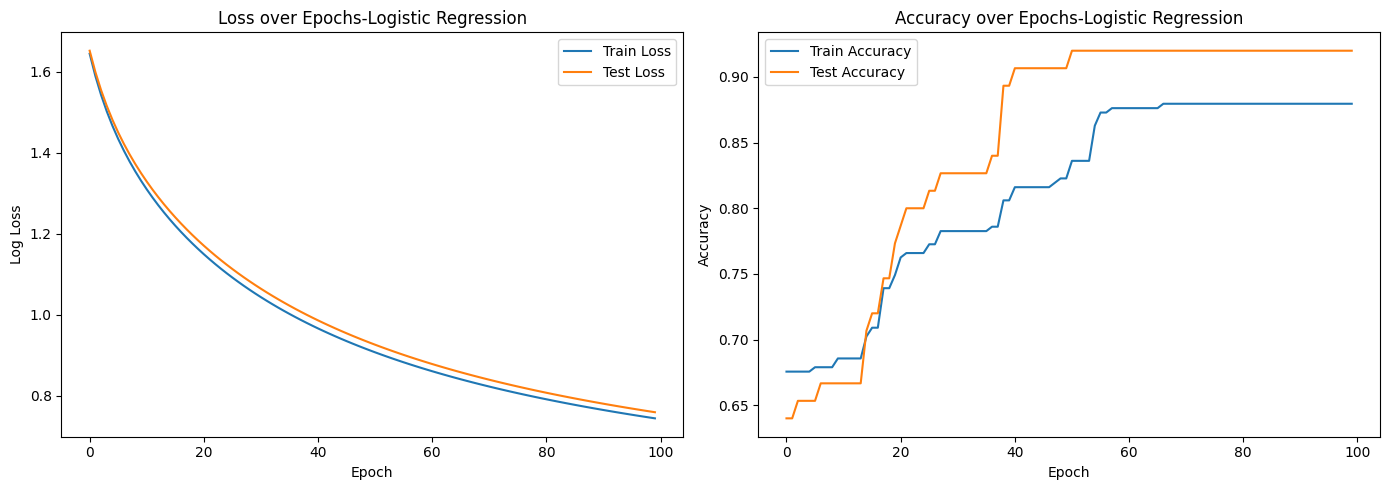

In [88]:
# Plot Learning Curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Loss over Epochs-Logistic Regression')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs-Logistic Regression')
plt.legend()

plt.tight_layout()
plt.show()

FINAL RESULTS AND PLOTS OF THE MODEL

 Classification Report:
              precision    recall  f1-score   support

           3       1.00      0.86      0.92        14
           4       0.88      1.00      0.93        14
           5       0.93      0.93      0.93        14
           6       0.89      0.89      0.89         9
           7       1.00      0.80      0.89        10
           8       0.88      1.00      0.93        14

    accuracy                           0.92        75
   macro avg       0.93      0.91      0.92        75
weighted avg       0.93      0.92      0.92        75



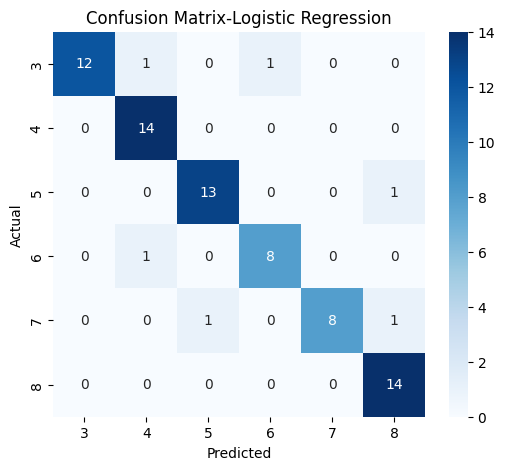

In [89]:
# FINAL PREDICTIONS
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)

# CLASSIFICATION REPORT
print(" Classification Report:")
print(classification_report(y_test, y_pred))

# CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix-Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

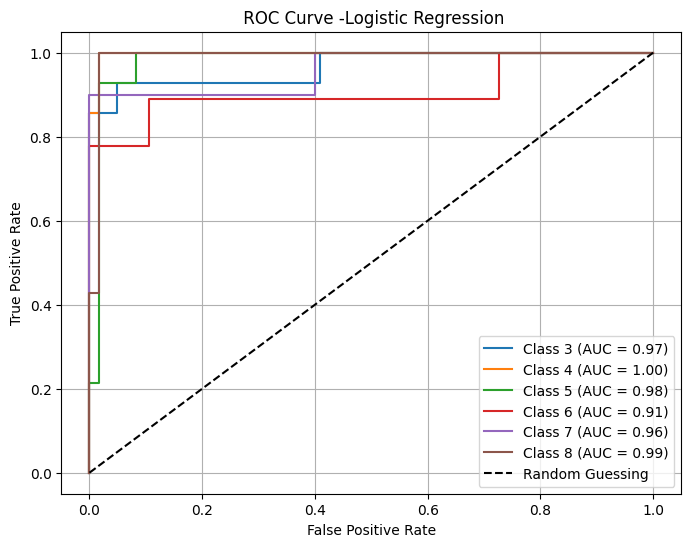

 Overall AUC Score: 0.97


In [90]:
# ROC CURVE

# Binarize output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=classes)
y_prob_bin = y_prob
n_classes = y_test_bin.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {np.unique(y)[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title(' ROC Curve -Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Overall AUC Score
overall_auc = roc_auc_score(y_test_bin, y_prob_bin, multi_class='ovr')
print(f" Overall AUC Score: {overall_auc:.2f}")

MODEL 2-RANDOM FOREST

In [60]:
# Importing necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss

In [61]:
# hypertuning parameters
param_grid = {
    'n_estimators': [ 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [62]:
# Set up the Random Forest model
rf = RandomForestClassifier(random_state=40)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_trainval_scaled, y_trainval)

# Print the best hyperparameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-validation Score: 0.9631638418079096


In [63]:
# Set up the RandomForestClassifier with the best hyperparameters
best_rf = RandomForestClassifier(random_state=40, **grid_search.best_params_)

# Train the model on the scaled training data
best_rf.fit(X_trainval_scaled, y_trainval)

# Make predictions on the scaled test data
y_pred_rf = best_rf.predict(X_test_scaled)

# Calculate and print the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Classifier Accuracy on Test Set: {accuracy_rf:.4f}")

Random Forest Classifier Accuracy on Test Set: 0.9867


In [64]:

# Helper Function

def random_selection_np(X, y, fraction=0.5, seed=None):
    """
    Randomly selects a subset (fraction) of X and y using NumPy indexing.
    """
    rng = np.random.RandomState(seed)
    total = len(X)
    subset_size = int(total * fraction)
    indices = rng.choice(total, subset_size, replace=False)

    X_subset = X[indices]
    y_subset = y.iloc[indices] if hasattr(y, 'iloc') else y[indices]

    return X_subset, y_subset


# Parameters
n_estimators_values = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900,
                       1000, 1200, 1500, 2000, 2500, 3000, 3500, 4000]
repeats = 5


# Extract grid search params
best_params = {
    k: v for k, v in grid_search.best_params_.items() if k != 'n_estimators'
}
best_params['class_weight'] = 'balanced'


# Storage for results
test_accuracies = []
train_accuracies = []
test_log_losses = []
train_log_losses = []


# Early Stopping Setup
best_test_loss = float('inf')
patience = 5
no_improve = 0


# Main Loop
for n in n_estimators_values:
    acc_test_all = []
    acc_train_all = []
    loss_test_all = []
    loss_train_all = []

    for rep in range(repeats):
        # Use custom NumPy random selection
        X_subset, y_subset = random_selection_np(X_trainval_scaled, y_trainval, fraction=0.5, seed=rep)

        # Train model
        rf_model = RandomForestClassifier(n_estimators=n, random_state=rep, **best_params)
        rf_model.fit(X_subset, y_subset)

        # Predict
        y_pred_test = rf_model.predict(X_test_scaled)
        y_pred_train = rf_model.predict(X_subset)

        # Accuracy
        acc_test_all.append(accuracy_score(y_test, y_pred_test))
        acc_train_all.append(accuracy_score(y_subset, y_pred_train))

        # Log Loss
        y_prob_test = rf_model.predict_proba(X_test_scaled)
        y_prob_train = rf_model.predict_proba(X_subset)
        loss_test_all.append(log_loss(y_test, y_prob_test))
        loss_train_all.append(log_loss(y_subset, y_prob_train))

    # Average over repeats
    test_acc_avg = np.mean(acc_test_all)
    train_acc_avg = np.mean(acc_train_all)
    test_loss_avg = np.mean(loss_test_all)
    train_loss_avg = np.mean(loss_train_all)

    test_accuracies.append(test_acc_avg)
    train_accuracies.append(train_acc_avg)
    test_log_losses.append(test_loss_avg)
    train_log_losses.append(train_loss_avg)

    print(f"n_estimators={n} | Test Acc: {test_acc_avg:.4f} | Train Acc: {train_acc_avg:.4f} | "
          f"Test Log Loss: {test_loss_avg:.4f} | Train Log Loss: {train_loss_avg:.4f}")


# Early stopping
    if test_loss_avg < best_test_loss:
        best_test_loss = test_loss_avg
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f" Early stopping at n_estimators = {n}")
            break




n_estimators=10 | Test Acc: 0.9547 | Train Acc: 0.9826 | Test Log Loss: 0.4116 | Train Log Loss: 0.0904
n_estimators=50 | Test Acc: 0.9680 | Train Acc: 0.9866 | Test Log Loss: 0.3919 | Train Log Loss: 0.0808
n_estimators=100 | Test Acc: 0.9600 | Train Acc: 0.9906 | Test Log Loss: 0.3086 | Train Log Loss: 0.0784
n_estimators=200 | Test Acc: 0.9600 | Train Acc: 0.9879 | Test Log Loss: 0.1535 | Train Log Loss: 0.0804
n_estimators=300 | Test Acc: 0.9600 | Train Acc: 0.9893 | Test Log Loss: 0.1522 | Train Log Loss: 0.0804
n_estimators=400 | Test Acc: 0.9600 | Train Acc: 0.9893 | Test Log Loss: 0.1528 | Train Log Loss: 0.0798
n_estimators=500 | Test Acc: 0.9600 | Train Acc: 0.9893 | Test Log Loss: 0.1545 | Train Log Loss: 0.0796
n_estimators=600 | Test Acc: 0.9653 | Train Acc: 0.9893 | Test Log Loss: 0.1532 | Train Log Loss: 0.0798
n_estimators=700 | Test Acc: 0.9653 | Train Acc: 0.9893 | Test Log Loss: 0.1528 | Train Log Loss: 0.0799
n_estimators=800 | Test Acc: 0.9627 | Train Acc: 0.9893 |

In [65]:
def random_selection_np(X, y, fraction=0.5, seed=None):
    """
    Randomly selects a subset (fraction) of X and y using NumPy indexing.
    """
    rng = np.random.RandomState(seed)
    total = len(X)
    subset_size = int(total * fraction)
    indices = rng.choice(total, subset_size, replace=False)

    X_subset = X[indices]
    y_subset = y.iloc[indices] if hasattr(y, 'iloc') else y[indices]

    return X_subset, y_subset


# Parameters
n_estimators_values = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900,
                       1000, 1200, 1500, 2000, 2500, 3000, 3500, 4000]
repeats = 5


# Extract grid search params
best_params = {
    k: v for k, v in grid_search.best_params_.items() if k != 'n_estimators'
}
best_params['class_weight'] = 'balanced'


# Storage for results
test_accuracies = []
train_accuracies = []
test_log_losses = []
train_log_losses = []




# Main Loop
for n in n_estimators_values:
    acc_test_all = []
    acc_train_all = []
    loss_test_all = []
    loss_train_all = []

    for rep in range(repeats):
        # Use custom NumPy random selection
        X_subset, y_subset = random_selection_np(X_trainval_scaled, y_trainval, fraction=0.5, seed=rep)

        # Train model
        rf_model = RandomForestClassifier(n_estimators=n, random_state=rep, **best_params)
        rf_model.fit(X_subset, y_subset)

        # Predict
        y_pred_test = rf_model.predict(X_test_scaled)
        y_pred_train = rf_model.predict(X_subset)

        # Accuracy
        acc_test_all.append(accuracy_score(y_test, y_pred_test))
        acc_train_all.append(accuracy_score(y_subset, y_pred_train))

        # Log Loss
        y_prob_test = rf_model.predict_proba(X_test_scaled)
        y_prob_train = rf_model.predict_proba(X_subset)
        loss_test_all.append(log_loss(y_test, y_prob_test))
        loss_train_all.append(log_loss(y_subset, y_prob_train))

    # Average over repeats
    test_acc_avg = np.mean(acc_test_all)
    train_acc_avg = np.mean(acc_train_all)
    test_loss_avg = np.mean(loss_test_all)
    train_loss_avg = np.mean(loss_train_all)

    test_accuracies.append(test_acc_avg)
    train_accuracies.append(train_acc_avg)
    test_log_losses.append(test_loss_avg)
    train_log_losses.append(train_loss_avg)

    print(f"n_estimators={n} | Test Acc: {test_acc_avg:.4f} | Train Acc: {train_acc_avg:.4f} | "
          f"Test Log Loss: {test_loss_avg:.4f} | Train Log Loss: {train_loss_avg:.4f}")


n_estimators=10 | Test Acc: 0.9547 | Train Acc: 0.9826 | Test Log Loss: 0.4116 | Train Log Loss: 0.0904
n_estimators=50 | Test Acc: 0.9680 | Train Acc: 0.9866 | Test Log Loss: 0.3919 | Train Log Loss: 0.0808
n_estimators=100 | Test Acc: 0.9600 | Train Acc: 0.9906 | Test Log Loss: 0.3086 | Train Log Loss: 0.0784
n_estimators=200 | Test Acc: 0.9600 | Train Acc: 0.9879 | Test Log Loss: 0.1535 | Train Log Loss: 0.0804
n_estimators=300 | Test Acc: 0.9600 | Train Acc: 0.9893 | Test Log Loss: 0.1522 | Train Log Loss: 0.0804
n_estimators=400 | Test Acc: 0.9600 | Train Acc: 0.9893 | Test Log Loss: 0.1528 | Train Log Loss: 0.0798
n_estimators=500 | Test Acc: 0.9600 | Train Acc: 0.9893 | Test Log Loss: 0.1545 | Train Log Loss: 0.0796
n_estimators=600 | Test Acc: 0.9653 | Train Acc: 0.9893 | Test Log Loss: 0.1532 | Train Log Loss: 0.0798
n_estimators=700 | Test Acc: 0.9653 | Train Acc: 0.9893 | Test Log Loss: 0.1528 | Train Log Loss: 0.0799
n_estimators=800 | Test Acc: 0.9627 | Train Acc: 0.9893 |

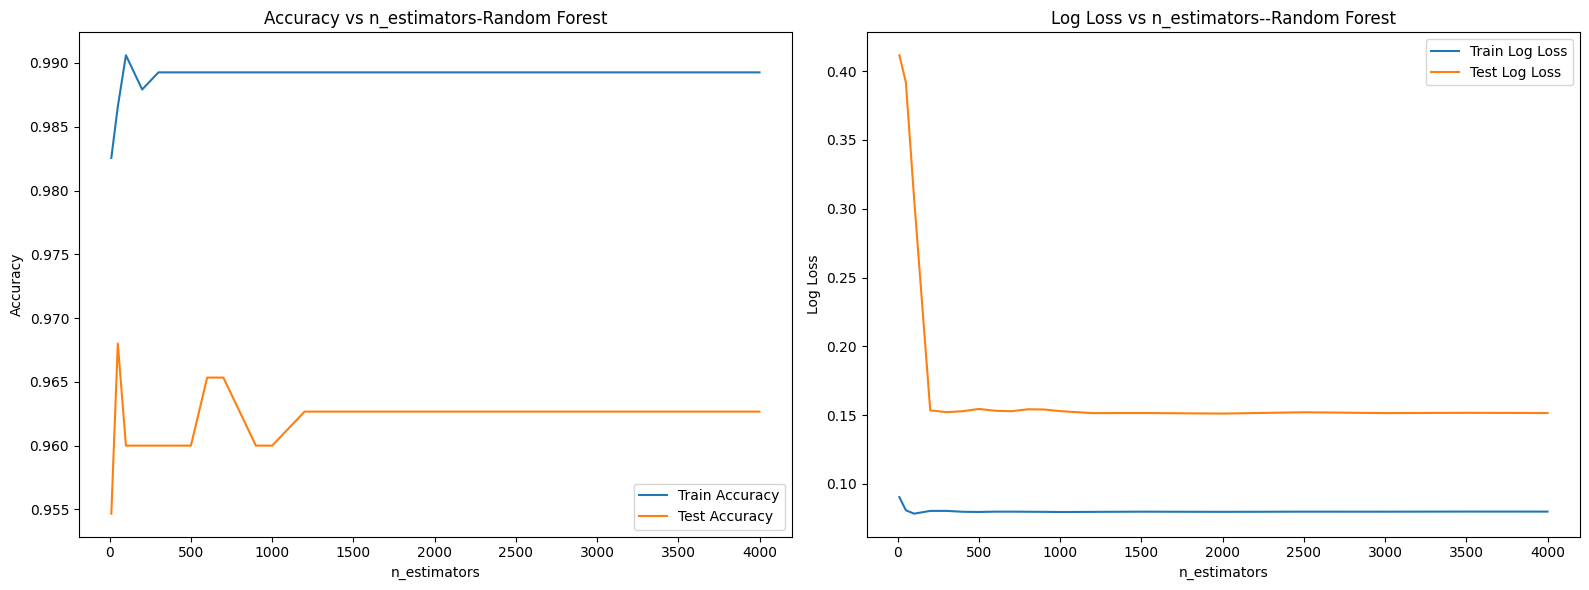

In [66]:


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#  Accuracy Plot
axes[0].plot(n_estimators_values[:len(train_accuracies)], train_accuracies, label="Train Accuracy")
axes[0].plot(n_estimators_values[:len(test_accuracies)], test_accuracies, label="Test Accuracy")
axes[0].set_xlabel("n_estimators")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy vs n_estimators-Random Forest")
axes[0].legend()

#  Log Loss Plot
axes[1].plot(n_estimators_values[:len(train_log_losses)], train_log_losses, label="Train Log Loss")
axes[1].plot(n_estimators_values[:len(test_log_losses)], test_log_losses, label="Test Log Loss")
axes[1].set_xlabel("n_estimators")
axes[1].set_ylabel("Log Loss")
axes[1].set_title("Log Loss vs n_estimators--Random Forest")
axes[1].legend()


# Show the plots
plt.tight_layout()
plt.show()


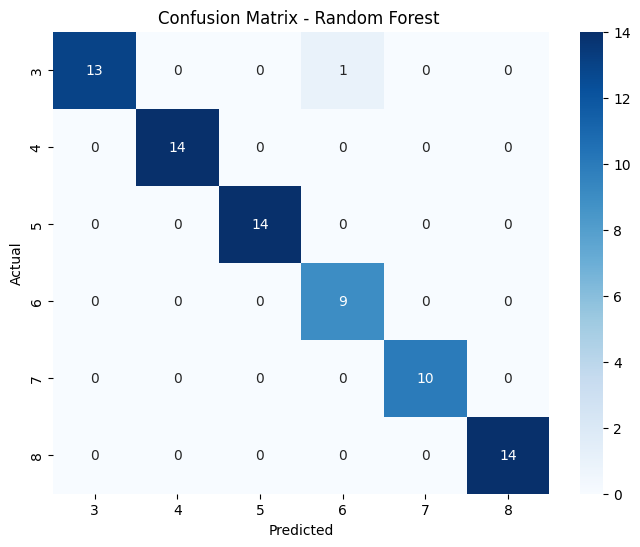

Classification Report - Random Forest :
              precision    recall  f1-score   support

           3       1.00      0.93      0.96        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        14
           6       0.90      1.00      0.95         9
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        14

    accuracy                           0.99        75
   macro avg       0.98      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



In [67]:
# CONFUSION MATRIX
y_pred_rf = best_rf.predict(X_test_scaled)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True,fmt ='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest ')
plt.show()

#  CLASSIFICATION REPORT
print("Classification Report - Random Forest :")
print(classification_report(y_test, y_pred_rf))


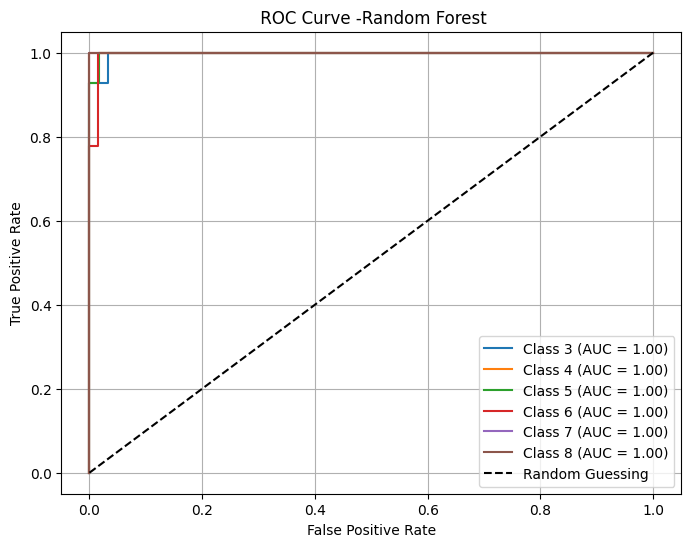

Overall AUC Score: 1.00


In [80]:
# ROC Curve
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_prob_bin = rf_model.predict_proba(X_test_scaled)

n_classes = y_test_bin.shape[1]

# Plotting the graph
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {np.unique(y)[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title(' ROC Curve -Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Overall AUC Score
overall_auc = roc_auc_score(y_test_bin, y_prob_bin, multi_class='ovr')
print(f"Overall AUC Score: {overall_auc:.2f}")

MODEL 3- SVM

In [69]:
from sklearn.svm import SVC

 Hyperparameter Tuning - Grid Search

In [70]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


In [71]:
# Define hyperparameter grid for SGDClassifier with hinge loss
param_grid_sgd_hinge = {
    'alpha': [0.0001, 0.001, 0.01],
    'eta0': [0.001, 0.01, 0.1],
    'penalty': ['l1', 'l2']
}

# Setting up the SGDClassifier with hinge loss
sgd_hinge = SGDClassifier(
    loss='hinge',
    learning_rate='constant',
    random_state=42
)

# Setting up the GridSearchCV
grid_search_sgd_hinge = GridSearchCV(
    estimator=sgd_hinge,
    param_grid=param_grid_sgd_hinge,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search_sgd_hinge.fit(X_trainval_scaled, y_trainval)

# Output best params and CV score
print("\nBest Hyperparameters for SVM :", grid_search_sgd_hinge.best_params_)
print("Best Cross-validation Score:", grid_search_sgd_hinge.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Hyperparameters for SVM : {'alpha': 0.001, 'eta0': 0.1, 'penalty': 'l2'}
Best Cross-validation Score: 0.8929943502824859


In [72]:
# Get best model from Grid Search
best_svm_model = grid_search_sgd_hinge.best_estimator_

# Predict on test data
y_test_pred = best_svm_model.predict(X_test_scaled)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nTest Accuracy for SVM :", test_accuracy)



Test Accuracy for SVM : 0.92


In [73]:
# Define multiclass hinge loss function
def multiclass_hinge_loss(y_true, decision_scores):
    n_samples = y_true.shape[0]
    correct_class_scores = decision_scores[np.arange(n_samples), y_true]
    margins = 1 + decision_scores - correct_class_scores[:, np.newaxis]
    margins[np.arange(n_samples), y_true] = 0
    losses = np.maximum(0, margins)
    return np.mean(np.max(losses, axis=1))


In [74]:


# Encode labels to zero-based integers
le = LabelEncoder()
y_trainval_enc = le.fit_transform(y_trainval)
y_test_enc = le.transform(y_test)

classes = np.unique(y_trainval_enc)

# Extract best hyperparameters from GridSearchCV
best_params = grid_search_sgd_hinge.best_params_
best_eta0 = best_params['eta0']
best_alpha = best_params['alpha']
best_penalty = best_params['penalty']

# Setting up the SGDClassifier with hinge loss and best params
svm_clf = SGDClassifier(
    loss='hinge',
    learning_rate='constant',
    eta0=0.001,
    alpha=best_alpha,
    penalty=best_penalty,
    max_iter=100,
    warm_start=True,
    random_state=42
)

epochs = 200
patience = 15
no_improve = 0
best_test_acc = 0

train_acc, test_acc = [], []
train_loss, test_loss = [], []

for epoch in range(epochs):
    if epoch == 0:
        svm_clf.partial_fit(X_trainval_scaled, y_trainval_enc, classes=classes)
    else:
        svm_clf.partial_fit(X_trainval_scaled, y_trainval_enc)

    # Predict labels
    y_train_pred = svm_clf.predict(X_trainval_scaled)
    y_test_pred = svm_clf.predict(X_test_scaled)

    # Get decision scores
    train_scores = svm_clf.decision_function(X_trainval_scaled)
    test_scores = svm_clf.decision_function(X_test_scaled)

    # Calculate accuracy
    acc_train = accuracy_score(y_trainval_enc, y_train_pred)
    acc_test = accuracy_score(y_test_enc, y_test_pred)

    # Calculate hinge loss
    loss_train = multiclass_hinge_loss(y_trainval_enc, train_scores)
    loss_test = multiclass_hinge_loss(y_test_enc, test_scores)

    train_acc.append(acc_train)
    test_acc.append(acc_test)
    train_loss.append(loss_train)
    test_loss.append(loss_test)

    print(f"Epoch {epoch+1:03d} | Train Acc: {acc_train:.4f} | Test Acc: {acc_test:.4f} | Train Loss: {loss_train:.4f} | Test Loss: {loss_test:.4f}")

    # Early stopping based on test accuracy
    if acc_test > best_test_acc:
        best_test_acc = acc_test
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break



Epoch 001 | Train Acc: 0.6656 | Test Acc: 0.6267 | Train Loss: 0.8303 | Test Loss: 0.8421
Epoch 002 | Train Acc: 0.6689 | Test Acc: 0.6267 | Train Loss: 0.7556 | Test Loss: 0.7697
Epoch 003 | Train Acc: 0.6722 | Test Acc: 0.6400 | Train Loss: 0.7248 | Test Loss: 0.7342
Epoch 004 | Train Acc: 0.6722 | Test Acc: 0.6400 | Train Loss: 0.7071 | Test Loss: 0.7108
Epoch 005 | Train Acc: 0.6689 | Test Acc: 0.6400 | Train Loss: 0.6928 | Test Loss: 0.6919
Epoch 006 | Train Acc: 0.6622 | Test Acc: 0.6400 | Train Loss: 0.6872 | Test Loss: 0.6763
Epoch 007 | Train Acc: 0.6522 | Test Acc: 0.6400 | Train Loss: 0.6874 | Test Loss: 0.6671
Epoch 008 | Train Acc: 0.6656 | Test Acc: 0.6400 | Train Loss: 0.6782 | Test Loss: 0.6509
Epoch 009 | Train Acc: 0.7191 | Test Acc: 0.7333 | Train Loss: 0.6689 | Test Loss: 0.6364
Epoch 010 | Train Acc: 0.7224 | Test Acc: 0.7333 | Train Loss: 0.6581 | Test Loss: 0.6207
Epoch 011 | Train Acc: 0.7224 | Test Acc: 0.7467 | Train Loss: 0.6429 | Test Loss: 0.6015
Epoch 012 

In [81]:
# Encode labels to zero-based integers
le = LabelEncoder()
y_trainval_enc = le.fit_transform(y_trainval)
y_test_enc = le.transform(y_test)

classes = np.unique(y_trainval_enc)

# Extract best hyperparameters from GridSearchCV
best_params = grid_search_sgd_hinge.best_params_
best_eta0 = best_params['eta0']
best_alpha = best_params['alpha']
best_penalty = best_params['penalty']

# Setting up the SGDClassifier with hinge loss and best params
svm_clf = SGDClassifier(
    loss='hinge',
    learning_rate='constant',
    eta0=0.001,
    alpha=best_alpha,
    penalty=best_penalty,
    max_iter=100,
    warm_start=True,
    random_state=42
)

epochs = 200
patience = 15
no_improve = 0
best_test_acc = 0

train_acc, test_acc = [], []
train_loss, test_loss = [], []

for epoch in range(epochs):
    if epoch == 0:
        svm_clf.partial_fit(X_trainval_scaled, y_trainval_enc, classes=classes)
    else:
        svm_clf.partial_fit(X_trainval_scaled, y_trainval_enc)

    # Predict labels
    y_train_pred = svm_clf.predict(X_trainval_scaled)
    y_test_pred = svm_clf.predict(X_test_scaled)

    # Get decision scores
    train_scores = svm_clf.decision_function(X_trainval_scaled)
    test_scores = svm_clf.decision_function(X_test_scaled)

    # Calculate accuracy
    acc_train = accuracy_score(y_trainval_enc, y_train_pred)
    acc_test = accuracy_score(y_test_enc, y_test_pred)

    # Calculate hinge loss
    loss_train = multiclass_hinge_loss(y_trainval_enc, train_scores)
    loss_test = multiclass_hinge_loss(y_test_enc, test_scores)

    train_acc.append(acc_train)
    test_acc.append(acc_test)
    train_loss.append(loss_train)
    test_loss.append(loss_test)

    print(f"Epoch {epoch+1:03d} | Train Acc: {acc_train:.4f} | Test Acc: {acc_test:.4f} | Train Loss: {loss_train:.4f} | Test Loss: {loss_test:.4f}")



Epoch 001 | Train Acc: 0.6656 | Test Acc: 0.6267 | Train Loss: 0.8303 | Test Loss: 0.8421
Epoch 002 | Train Acc: 0.6689 | Test Acc: 0.6267 | Train Loss: 0.7556 | Test Loss: 0.7697
Epoch 003 | Train Acc: 0.6722 | Test Acc: 0.6400 | Train Loss: 0.7248 | Test Loss: 0.7342
Epoch 004 | Train Acc: 0.6722 | Test Acc: 0.6400 | Train Loss: 0.7071 | Test Loss: 0.7108
Epoch 005 | Train Acc: 0.6689 | Test Acc: 0.6400 | Train Loss: 0.6928 | Test Loss: 0.6919
Epoch 006 | Train Acc: 0.6622 | Test Acc: 0.6400 | Train Loss: 0.6872 | Test Loss: 0.6763
Epoch 007 | Train Acc: 0.6522 | Test Acc: 0.6400 | Train Loss: 0.6874 | Test Loss: 0.6671
Epoch 008 | Train Acc: 0.6656 | Test Acc: 0.6400 | Train Loss: 0.6782 | Test Loss: 0.6509
Epoch 009 | Train Acc: 0.7191 | Test Acc: 0.7333 | Train Loss: 0.6689 | Test Loss: 0.6364
Epoch 010 | Train Acc: 0.7224 | Test Acc: 0.7333 | Train Loss: 0.6581 | Test Loss: 0.6207
Epoch 011 | Train Acc: 0.7224 | Test Acc: 0.7467 | Train Loss: 0.6429 | Test Loss: 0.6015
Epoch 012 

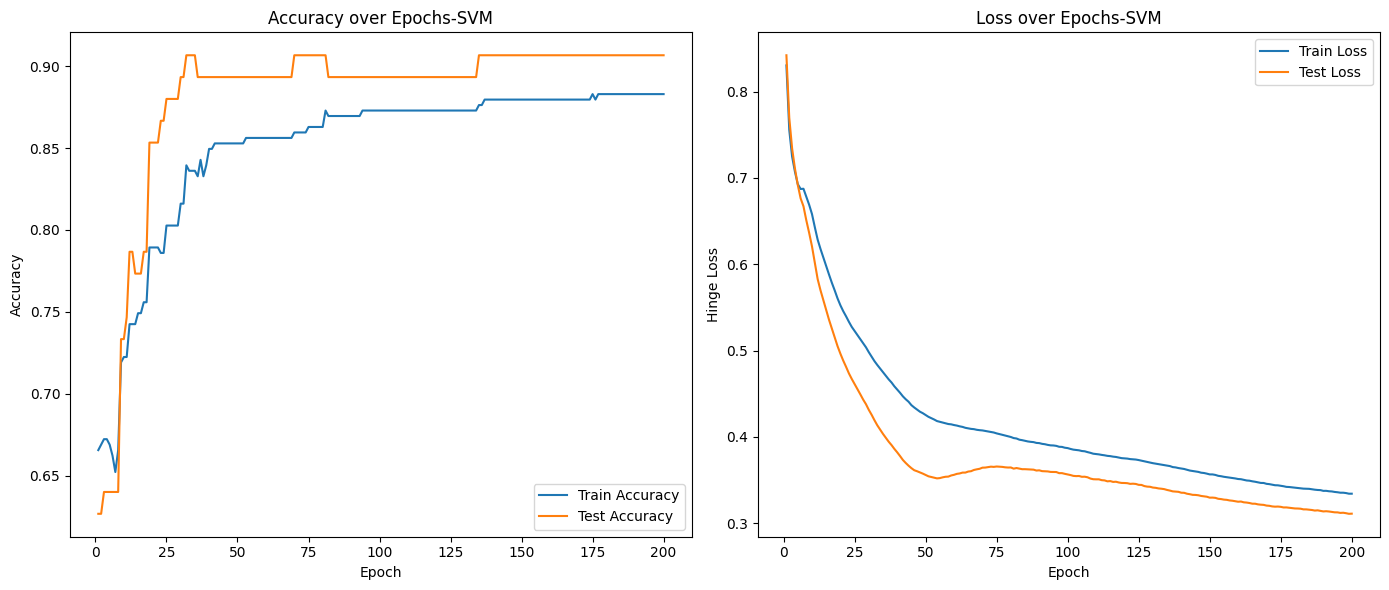

In [76]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs-SVM')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Hinge Loss')
plt.title('Loss over Epochs-SVM')
plt.legend()

plt.tight_layout()
plt.show()

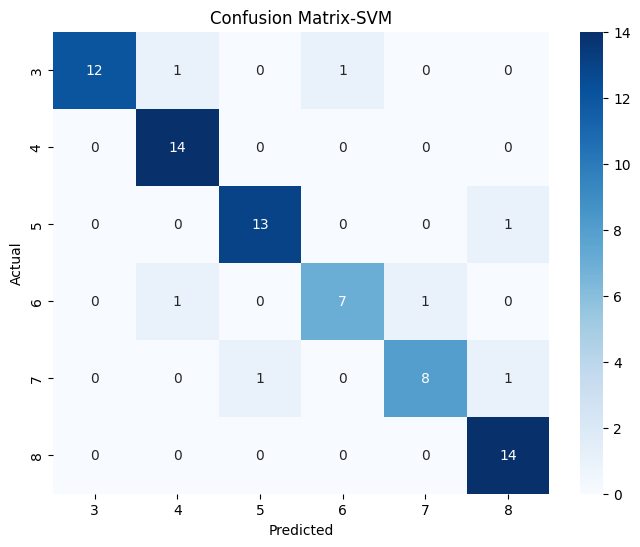

Classification Report-SVM:
              precision    recall  f1-score   support

           3       1.00      0.86      0.92        14
           4       0.88      1.00      0.93        14
           5       0.93      0.93      0.93        14
           6       0.88      0.78      0.82         9
           7       0.89      0.80      0.84        10
           8       0.88      1.00      0.93        14

    accuracy                           0.91        75
   macro avg       0.91      0.89      0.90        75
weighted avg       0.91      0.91      0.91        75



In [77]:
# Get final predictions on test set
final_y_pred = svm_clf.predict(X_test_scaled)

# Reverse label encoding to get original class labels
final_y_pred_labels = le.inverse_transform(final_y_pred)
y_test_labels = le.inverse_transform(y_test_enc)

# Confusion Matrix
cm = confusion_matrix(y_test_labels, final_y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix-SVM')
plt.show()

# Classification Report
print("Classification Report-SVM:")
print(classification_report(y_test_labels, final_y_pred_labels))


/tmp/ipython-input-2709696504.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2',n_classes)


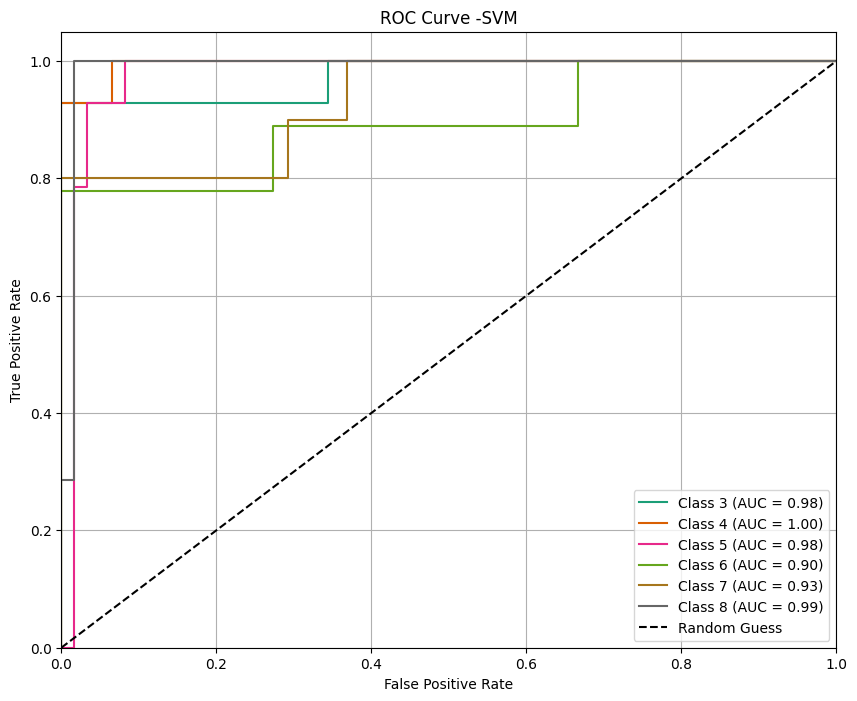

Overall AUC Score: 0.96


In [78]:
# Get unique classes
classes = np.unique(y_trainval_enc)

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test_enc, classes=classes)
y_prob_bin = svm_clf.decision_function(X_test_scaled)
n_classes = y_test_bin.shape[1]

# Compute ROC and AUC per class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#  Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Dark2',n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"Class {le.inverse_transform([classes[i]])[0]} (AUC = {roc_auc[i]:.2f})",
             color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve -SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Overall AUC Score
overall_auc = roc_auc_score(y_test_bin, y_prob_bin, multi_class='ovr')
print(f"Overall AUC Score: {overall_auc:.2f}")
